## Persistence Landscapes

- vectorized representations of persistence diagrams
    - allow for statistical analyses (can't do statistics with persistence diagrams because they are not in a vector space & do not have a true mean)

### This notebook generates persistence landscapes: 
- per homology group rank (ex H0, H1, or H2)
- per stimuli
- per region

note: can also do difference landscapes using persim 

Author: @emilyekstrum
<br> 12/7/25

In [1]:
# import modules
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from persim import PersLandscapeApprox
from persim.landscapes import average_approx
from persim.landscapes import snap_pl
from persim.landscapes import plot_landscape_simple
import os
from matplotlib.lines import Line2D
import numpy as np
from typing import Optional, Tuple, Sequence, Any  

In [2]:
# import TDA utilities
import sys
from pathlib import Path

# add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository")
    raise

Spike data already available.
All persistence diagrams already available.
TDA utilities loaded


## 1. Load in and inspect ALL dgms files 

- from all_dgms.zip 
- should use all_dgms - otherwise some plots will not have data to populate

In [3]:
# create data manager instance
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# get all persistence files
all_dgms_files = data_manager.get_all_persistence_files()

print(f"\n{len(all_dgms_files)} persistence diagram files available")

# persistence diagram (dgms) files by source
persistence_examples = [f for f in all_dgms_files if 'persistence_examples' in str(f)]
cebra_files = [f for f in all_dgms_files if 'CEBRA_' in f.name]

print(f"  From persistence_examples directory: {len(persistence_examples)}")
print(f"  From CEBRA files (all_dgms.zip): {len(cebra_files)}")

if cebra_files:
    print("\nFirst 10 CEBRA dgms files:")
    for i, f in enumerate(cebra_files[:10]):
        print(f"  {i+1:2d}. {f.name}")
    
    # dgms files by brain area
    lgn_files = [f for f in cebra_files if 'LGN' in f.name]
    v1_files = [f for f in cebra_files if 'V1' in f.name]
    print(f"\ndgms files availble by brain area:")
    print(f"  LGN files: {len(lgn_files)}")
    print(f"  V1 files: {len(v1_files)}")
    
    # dgms files by stimulus breakdown
    stimuli = ['cex', 'dg', 'cg', 'lf']
    print(f"\ndgms files available by stimulus:")
    for stimulus in stimuli:
        stimulus_files = [f for f in cebra_files if stimulus in f.name]
        print(f"  {stimulus}: {len(stimulus_files)} files")

    # dgms files by shuffled vs. non-shuffled
    shuffled_files = [f for f in cebra_files if 'shuffled' in f.name]
    non_shuffled_files = [f for f in cebra_files if 'shuffled' not in f.name]
    print(f"\ndgms files available by shuffled status:")
    print(f"  Shuffled files: {len(shuffled_files)}")
    print(f"  Non-shuffled files: {len(non_shuffled_files)}")
    
else:
    print("\nNo CEBRA files found.")


98 persistence diagram files available
  From persistence_examples directory: 0
  From CEBRA files (all_dgms.zip): 98

First 10 CEBRA dgms files:
   1. CEBRA_24d_LGN_cex_C153.pkl
   2. CEBRA_24d_LGN_cex_C159.pkl
   3. CEBRA_24d_LGN_cg_C161.pkl
   4. CEBRA_24d_LGN_dg_C161.pkl
   5. CEBRA_24d_LGN_lf_C160.pkl
   6. CEBRA_24d_LGN_lf_d6.pkl
   7. CEBRA_24d_V1_cex_C153.pkl
   8. CEBRA_24d_V1_cex_C160.pkl
   9. CEBRA_24d_V1_cex_C161.pkl
  10. CEBRA_24d_V1_cg_C161.pkl

dgms files availble by brain area:
  LGN files: 39
  V1 files: 59

dgms files available by stimulus:
  cex: 34 files
  dg: 13 files
  cg: 8 files
  lf: 19 files

dgms files available by shuffled status:
  Shuffled files: 8
  Non-shuffled files: 90


In [4]:
# file parsing utils
# RUN ME

stim_map = {
    "dg": "drifting_gratings",
    "cg": "chromatic_gratings",
    "ce": "color_exchange",
    "lf": "luminance_flash",
}

def parse_filename(fname: str):
    """ Parse filename to get method, embed_dim, region, stim, mouse 
    
    Args:
        fname (str): filename
    Returns:
        dict: method, embed_dim, region, stim, mouse"""

    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)
    parts = name.split("_")

    if len(parts) < 5:
        raise ValueError(f"Unexpected filename structure: {fname}")

    method = parts[0]
    embed_dim = parts[1]   
    region = parts[2]      
    stim_code = parts[3]   
    mouse = parts[4] 
    is_shuffled = 'shuffled' in name     

    stim = stim_map.get(stim_code, stim_code)

    return {
        "method": method,
        "embed_dim": embed_dim,
        "region": region,
        "stim": stim,
        "mouse": mouse,
        "is_shuffled": shuffled
    }

def load_dgms(path: str):
    """ Load diagrams from pickle file
    
    Args:
        path (str): path to pickle file
    Returns:
        list: diagrams"""

    with open(path, "rb") as f:
        dgms = pkl.load(f)
    return dgms

## 2. Organize files by brain area and calculate average persistence landscapes (non-shuffled)

In [10]:
# average landscapes for each homology group (H0, H1, H2)
avg_lgn_landscapes = {}
avg_v1_landscapes = {}

# filter files by region and no shuffling using the loaded dgms files
LGN_files = [f for f in all_dgms_files if "LGN" in f.name and 'shuffled' not in f.name ]
V1_files = [f for f in all_dgms_files if "V1" in f.name and 'shuffled' not in f.name ]

print(f"{len(LGN_files)} LGN dgms files and {len(V1_files)} V1 dgms files available")

for hom_deg in range(3): 
    LGN_landscapes = []
    V1_landscapes = []
    
    # Process LGN files
    for fpath in LGN_files:
        try:
            dgms = data_manager.load_persistence_diagrams(fpath)
            if dgms and len(dgms) > hom_deg:
                if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                    persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    LGN_landscapes.append(persistence_landscape)
        except Exception as e:
            print(f"Error processing LGN {fpath.name}: {e}")
            continue
    
    # Process V1 files
    for fpath in V1_files:
        try:
            dgms = data_manager.load_persistence_diagrams(fpath)
            if dgms and len(dgms) > hom_deg:
                if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                    persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    V1_landscapes.append(persistence_landscape)
        except Exception as e:
            print(f"Error processing V1 {fpath.name}: {e}")
            continue
    
    # Average persistence landscapes 
    if LGN_landscapes:
        avg_lgn_landscapes[f'H{hom_deg}'] = average_approx(LGN_landscapes)
    else:
        print(f"No valid LGN landscapes found for H{hom_deg}")
        
    if V1_landscapes:
        avg_v1_landscapes[f'H{hom_deg}'] = average_approx(V1_landscapes)
    else:
        print(f"No valid V1 landscapes found for H{hom_deg}")

# extract individual landscapes for each homology group - used later
avg_lgn_h0_landscape = avg_lgn_landscapes.get('H0')
avg_lgn_h1_landscape = avg_lgn_landscapes.get('H1')
avg_lgn_h2_landscape = avg_lgn_landscapes.get('H2')
avg_v1_h0_landscape = avg_v1_landscapes.get('H0')
avg_v1_h1_landscape = avg_v1_landscapes.get('H1')
avg_v1_h2_landscape = avg_v1_landscapes.get('H2')

31 LGN dgms files and 59 V1 dgms files available


## Organize by brain area - for shuffled dgms

In [7]:
# average landscapes for each homology group (H0, H1, H2)
avg_lgn_landscapes_shuffled = {}
avg_v1_landscapes_shuffled = {}

# filter files by region and shuffling using the loaded dgms files
LGN_files_shuffled = [f for f in all_dgms_files if "LGN" in f.name and 'shuffled' in f.name]
V1_files_shuffled = [f for f in all_dgms_files if "V1" in f.name and 'shuffled' in f.name]

print(f"{len(LGN_files_shuffled)} shuffled LGN dgms files and {len(V1_files_shuffled)} shuffled V1 dgms files available")

for hom_deg in range(3): 
    LGN_landscapes_shuffled = []
    V1_landscapes_shuffled = []
    
    # Process LGN files
    for fpath in LGN_files_shuffled:
        try:
            dgms = data_manager.load_persistence_diagrams(fpath)
            if dgms and len(dgms) > hom_deg:
                if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                    persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    LGN_landscapes_shuffled.append(persistence_landscape)
        except Exception as e:
            print(f"Error processing LGN {fpath.name}: {e}")
            continue
    
    # Process V1 files
    for fpath in V1_files_shuffled:
        try:
            dgms = data_manager.load_persistence_diagrams(fpath)
            if dgms and len(dgms) > hom_deg:
                if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                    persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    V1_landscapes_shuffled.append(persistence_landscape)
        except Exception as e:
            print(f"Error processing V1 {fpath.name}: {e}")
            continue
    
    # Average persistence landscapes 
    if LGN_landscapes_shuffled:
        avg_lgn_landscapes_shuffled[f'H{hom_deg}'] = average_approx(LGN_landscapes_shuffled)
    else:
        print(f"No valid shuffled LGN landscapes found for H{hom_deg}")
        
    if V1_landscapes_shuffled:
        avg_v1_landscapes_shuffled[f'H{hom_deg}'] = average_approx(V1_landscapes_shuffled)
    else:
        print(f"No valid shuffled V1 landscapes found for H{hom_deg}")

# extract individual landscapes for each homology group - used later
avg_lgn_h0_landscape_shuffled = avg_lgn_landscapes_shuffled.get('H0')
avg_lgn_h1_landscape_shuffled = avg_lgn_landscapes_shuffled.get('H1')
avg_lgn_h2_landscape_shuffled = avg_lgn_landscapes_shuffled.get('H2')
avg_v1_h0_landscape_shuffled = avg_v1_landscapes_shuffled.get('H0')
avg_v1_h1_landscape_shuffled = avg_v1_landscapes_shuffled.get('H1')
avg_v1_h2_landscape_shuffled = avg_v1_landscapes_shuffled.get('H2')

8 shuffled LGN dgms files and 0 shuffled V1 dgms files available
No valid shuffled V1 landscapes found for H0
No valid shuffled V1 landscapes found for H1
No valid shuffled V1 landscapes found for H2


### TDA mini lession: Persistence Landscapes

![persist_landscape](persistence_landscape_slide.png)

### Persistence landscapes are stable vectorized representations of persistence diagrams.
They plot summaries (vectors) of descending persistent topological features. 
How a persistence landscape is plotted from a persistence diagram: 
1. The coordinates are adjusting from birth and death (eps) to half-life on the y-axis and midpoint on the x-axis. 
2. For each point (topological feature) in a persistence diagram, a piecewise triangular funciton is fit (fi(m)).
3. The greatest fi(m) at each midpoint value is then summarized in a lambda function. 
    - It is easy to think of the persistence landscape as mountain range, with the lambda functions fitting different levels of the mountain range.
    - The zeroth lambda function captures the most persistent features by describing the 'tallest mountain peaks', or the max values of all piecewise functions.
    - Subsequent lambda functions describe decreasing layers of the persistence landscape. So, the lambda function rank is inversely related to the strength/persistence of the topological features it describes.

## 3. Plot average persistence landscapes per brain area per homology group

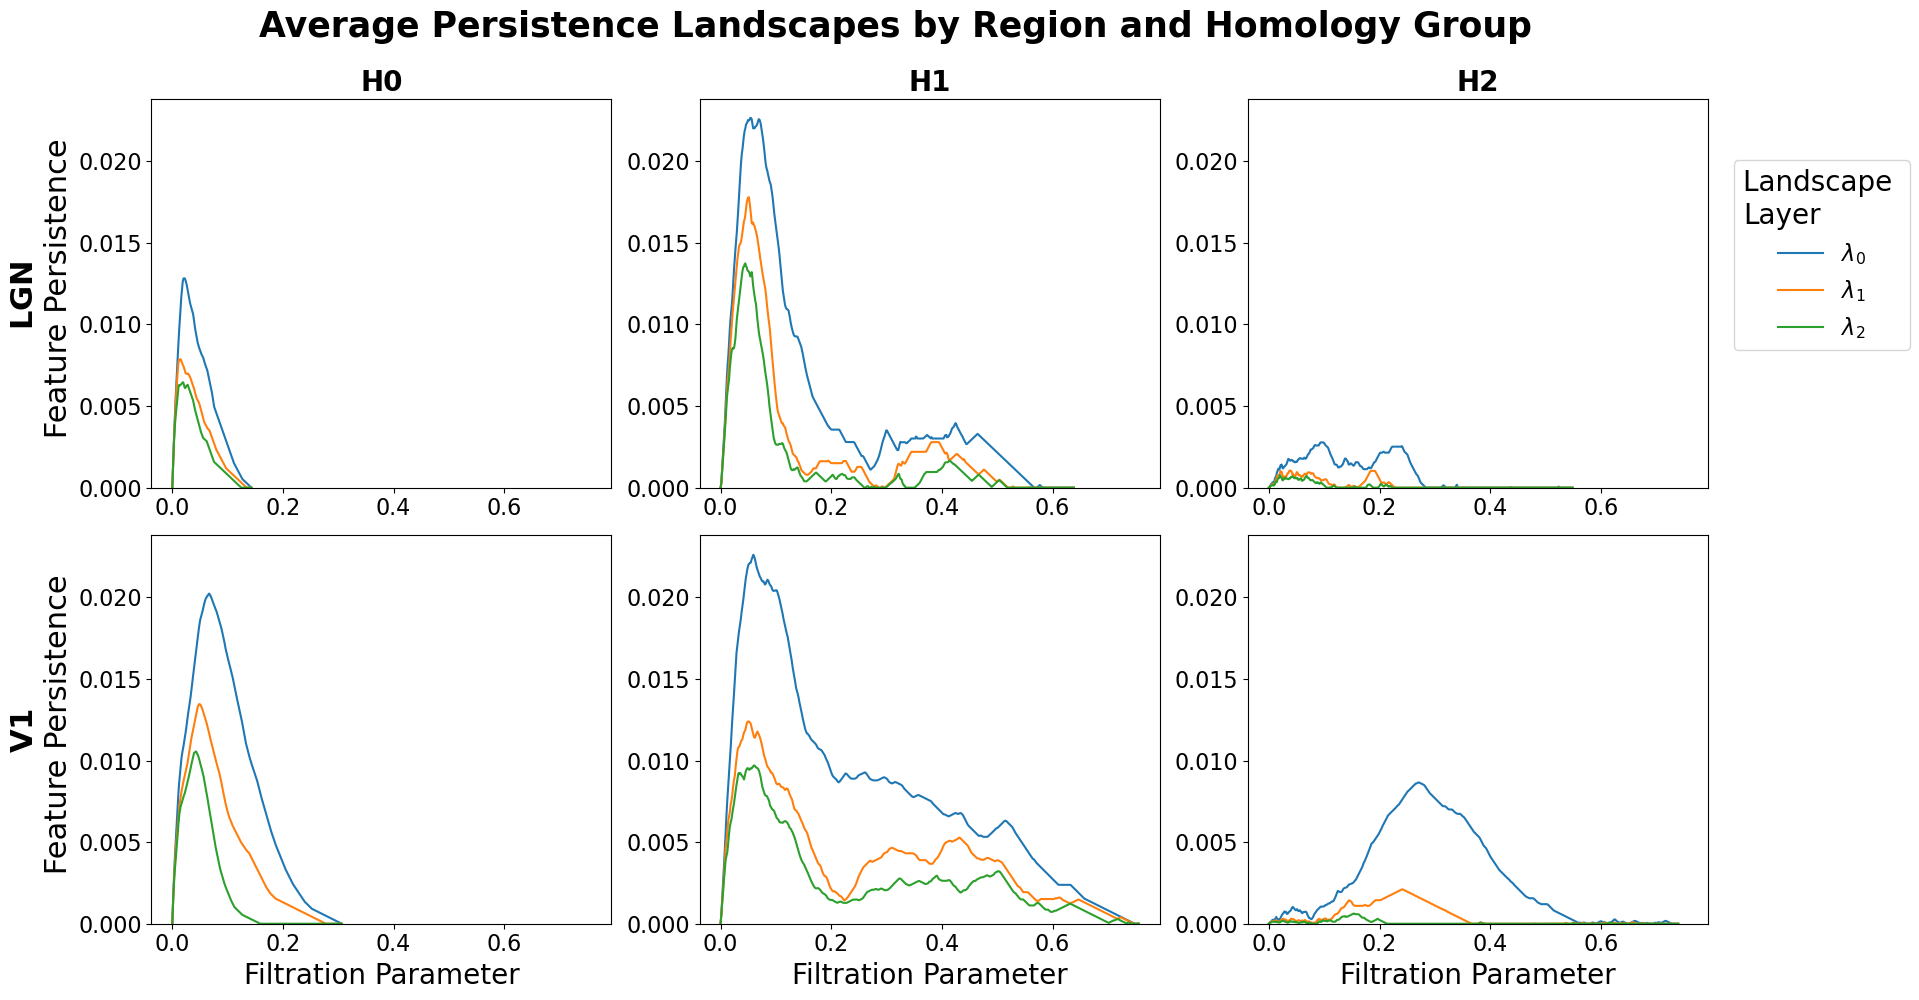

In [11]:
shuffled = False  # set to True to plot shuffled landscapes, False for non-shuffled

if shuffled:
    avg_lgn_h0_landscape = avg_lgn_h0_landscape_shuffled
    avg_lgn_h1_landscape = avg_lgn_h1_landscape_shuffled
    avg_lgn_h2_landscape = avg_lgn_h2_landscape_shuffled
    avg_v1_h0_landscape = avg_v1_h0_landscape_shuffled
    avg_v1_h1_landscape = avg_v1_h1_landscape_shuffled
    avg_v1_h2_landscape = avg_v1_h2_landscape_shuffled

else:
    pass  # keep non-shuffled landscapes


# plot average persistence landscapes for V1 and LGN for each homology group

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# landscapes and labels
landscapes = {
    'LGN': {
        'H0': avg_lgn_h0_landscape,
        'H1': avg_lgn_h1_landscape,
        'H2': avg_lgn_h2_landscape
    },
    'V1': {
        'H0': avg_v1_h0_landscape,
        'H1': avg_v1_h1_landscape,
        'H2': avg_v1_h2_landscape
    }
}

homology_groups = ['H0', 'H1', 'H2']
regions = ['LGN', 'V1']

def count_valid_diagrams(file_list, hom_deg):
    """ Count diagrams in a list of files

    Args:
        file_list (list): list of file names
        hom_deg (int): homology group degree

    Returns:
        int: number of valid diagrams"""

    count = 0
    for fname in file_list:
        try:
            dgms = load_dgms(fpath)
            if isinstance(dgms, np.ndarray):
                dgms = dgms.tolist()
            if dgms and len(dgms) > hom_deg:
                dgm = dgms[hom_deg]
                if dgm is not None and len(dgm) > 0:
                    count += 1
        except Exception:
            continue
    return count

diagram_counts = {
    'LGN': {group: count_valid_diagrams(LGN_files, int(group[1])) for group in homology_groups},
    'V1': {group: count_valid_diagrams(V1_files, int(group[1])) for group in homology_groups}
}

# calculate global x and y limits across all landscapes
all_x_values = []
all_y_values = []

for region in regions:
    for group in homology_groups:
        landscape = landscapes[region][group]
        try:
            xs = landscape.grid
        except AttributeError:
            try:
                xs = landscape.xs
            except AttributeError:
                xs = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
        
        try:
            landscapes_data = landscape.landscapes
        except AttributeError:
            try:
                landscapes_data = landscape.values
            except AttributeError:
                landscapes_data = landscape.Ls
        
        all_x_values.extend(xs)
        # get y values from first 10 lambda function
        n_layers = min(10, len(landscapes_data))
        for i in range(n_layers):
            all_y_values.extend(landscapes_data[i])

# global limits
x_min = min(all_x_values)
x_max = max(all_x_values)
y_min = min(all_y_values)
y_max = max(all_y_values)

# small padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min = max(0, y_min - y_padding)  # don't go below 0 for y
y_max += y_padding

# plot landscapes using plot_landscape_simple()
for row_idx, region in enumerate(regions):
    for col_idx, group in enumerate(homology_groups):
        ax = axes[row_idx, col_idx]
        landscape = landscapes[region][group]
        
        # set current axes and plot using plot_landscape_simple()
        plt.sca(ax)
        plot_landscape_simple(landscape, title="", depth_range=range(3))
        
        # remove legend from individual subplot
        ax.legend().remove()
        
        # set the same axis limits for all subplots
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='x', labelsize=16) 
        ax.tick_params(axis='y', labelsize=16)

        # set labels
        if row_idx == 0:
            ax.set_title(
                f"{homology_groups[col_idx]}",
                fontsize=20,
                fontweight='bold'
            )
        if col_idx == 0:
            ax.set_ylabel(f"$\\bf{{{region}}}$ \n Feature Persistence", fontsize=22)
        
        # set axis labels for bottom row
        if row_idx == 1:
            ax.set_xlabel("Filtration Parameter", fontsize=20)
            


handles, labels = axes[0, 0].get_legend_handles_labels()
if len(handles) == 0:
    handles = [Line2D([0], [0], color=plt.cm.viridis(i/9), linewidth=1.5) for i in range(3)]
    labels = [f'λ{i}' for i in range(3)]

#fig.text(0.955, 0.9, f"n={diagram_counts['LGN']['H0']}", transform=fig.transFigure, fontsize=16, ha='left', va='top', bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
#fig.text(0.955, 0.46, f"n={diagram_counts['V1']['H0']}", transform=fig.transFigure, fontsize=16, ha='left', va='top', bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.75), title='Landscape \nLayer', fontsize=16, title_fontsize=20)

fig.suptitle('Average Persistence Landscapes by Region and Homology Group', fontsize=25, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 0.96, 1]) 
plt.show()


## 4. Organize dgms files by stimulus
- Can specify homology degree by adjusting ```hom_deg```

- Can specify embedding dimension by adjusting ```dim```

In [ ]:
hom_deg = 1 # 0, 1, or 2
dim = "32d" # empty for all dims or 3d, 8d, 24d, 32d
shuffled = False  # True for shuffled, False for non-shuffled

if shuffled:
    LGN_files = [f for f in all_dgms_files if 'shuffled' in f.name]
    V1_files = [f for f in all_dgms_files if 'shuffled' in f.name]
else:
    LGN_files = [f for f in all_dgms_files if 'shuffled' not in f.name]
    V1_files = [f for f in all_dgms_files if 'shuffled' not in f.name]

lgn_cex_files = [f for f in LGN_files if f.suffix == ".pkl" and "cex" in f.name and "LGN" in f.name and dim in f.name]
lgn_lf_files = [f for f in LGN_files if f.suffix == ".pkl" and "lf" in f.name and "LGN" in f.name and dim in f.name]
lgn_dg_files = [f for f in LGN_files if f.suffix == ".pkl" and "dg" in f.name and "LGN" in f.name and dim in f.name]
lgn_cg_files = [f for f in LGN_files if f.suffix == ".pkl" and "cg" in f.name and "LGN" in f.name and dim in f.name]

v1_cex_files = [f for f in V1_files if f.suffix == ".pkl" and "cex" in f.name and "V1" in f.name and dim in f.name]
v1_lf_files = [f for f in V1_files if f.suffix == ".pkl" and "lf" in f.name and "V1" in f.name and dim in f.name]
v1_dg_files = [f for f in V1_files if f.suffix == ".pkl" and "dg" in f.name and "V1" in f.name and dim in f.name]
v1_cg_files = [f for f in V1_files if f.suffix == ".pkl" and "cg" in f.name and "V1" in f.name and dim in f.name]


lgn_CEX_landscape, lgn_LF_landscape, lgn_DG_landscape, lgn_CG_landscape = [], [], [], []
v1_CEX_landscape, v1_LF_landscape, v1_DG_landscape, v1_CG_landscape = [], [], [], []

for f in lgn_cex_files:
        # load diagrams
        dgms = load_dgms(f)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_CEX_landscape.append(persistence_landscape)

for f in v1_cex_files:
        # load diagrams
        dgms = load_dgms(f)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_CEX_landscape.append(persistence_landscape)


for f in lgn_lf_files:
        # load diagrams
        dgms = load_dgms(f)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_LF_landscape.append(persistence_landscape)

for f in v1_lf_files:
        # load diagrams
        dgms = load_dgms(f)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_LF_landscape.append(persistence_landscape)

for f in lgn_dg_files:
        # load diagrams
        dgms = load_dgms(f)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_DG_landscape.append(persistence_landscape)

for f in v1_dg_files:
        # load diagrams
        dgms = load_dgms(f)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_DG_landscape.append(persistence_landscape)

for f in lgn_cg_files:
        # load diagrams
        dgms = load_dgms(f)

        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_CG_landscape.append(persistence_landscape)

for f in v1_cg_files:
        # load diagrams
        dgms = load_dgms(f)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_CG_landscape.append(persistence_landscape)

#average persistence landscapes
avg_lgn_CEX_landscape = average_approx(lgn_CEX_landscape)
avg_lgn_LF_landscape = average_approx(lgn_LF_landscape)
avg_lgn_DG_landscape = average_approx(lgn_DG_landscape)
avg_lgn_CG_landscape = average_approx(lgn_CG_landscape)

avg_v1_CEX_landscape = average_approx(v1_CEX_landscape)
avg_v1_LF_landscape = average_approx(v1_LF_landscape)
avg_v1_DG_landscape = average_approx(v1_DG_landscape)
avg_v1_CG_landscape = average_approx(v1_CG_landscape)

## 5. Plot persistence landscapes by brain region and stimulus per specified embedding dimensionality and homology group

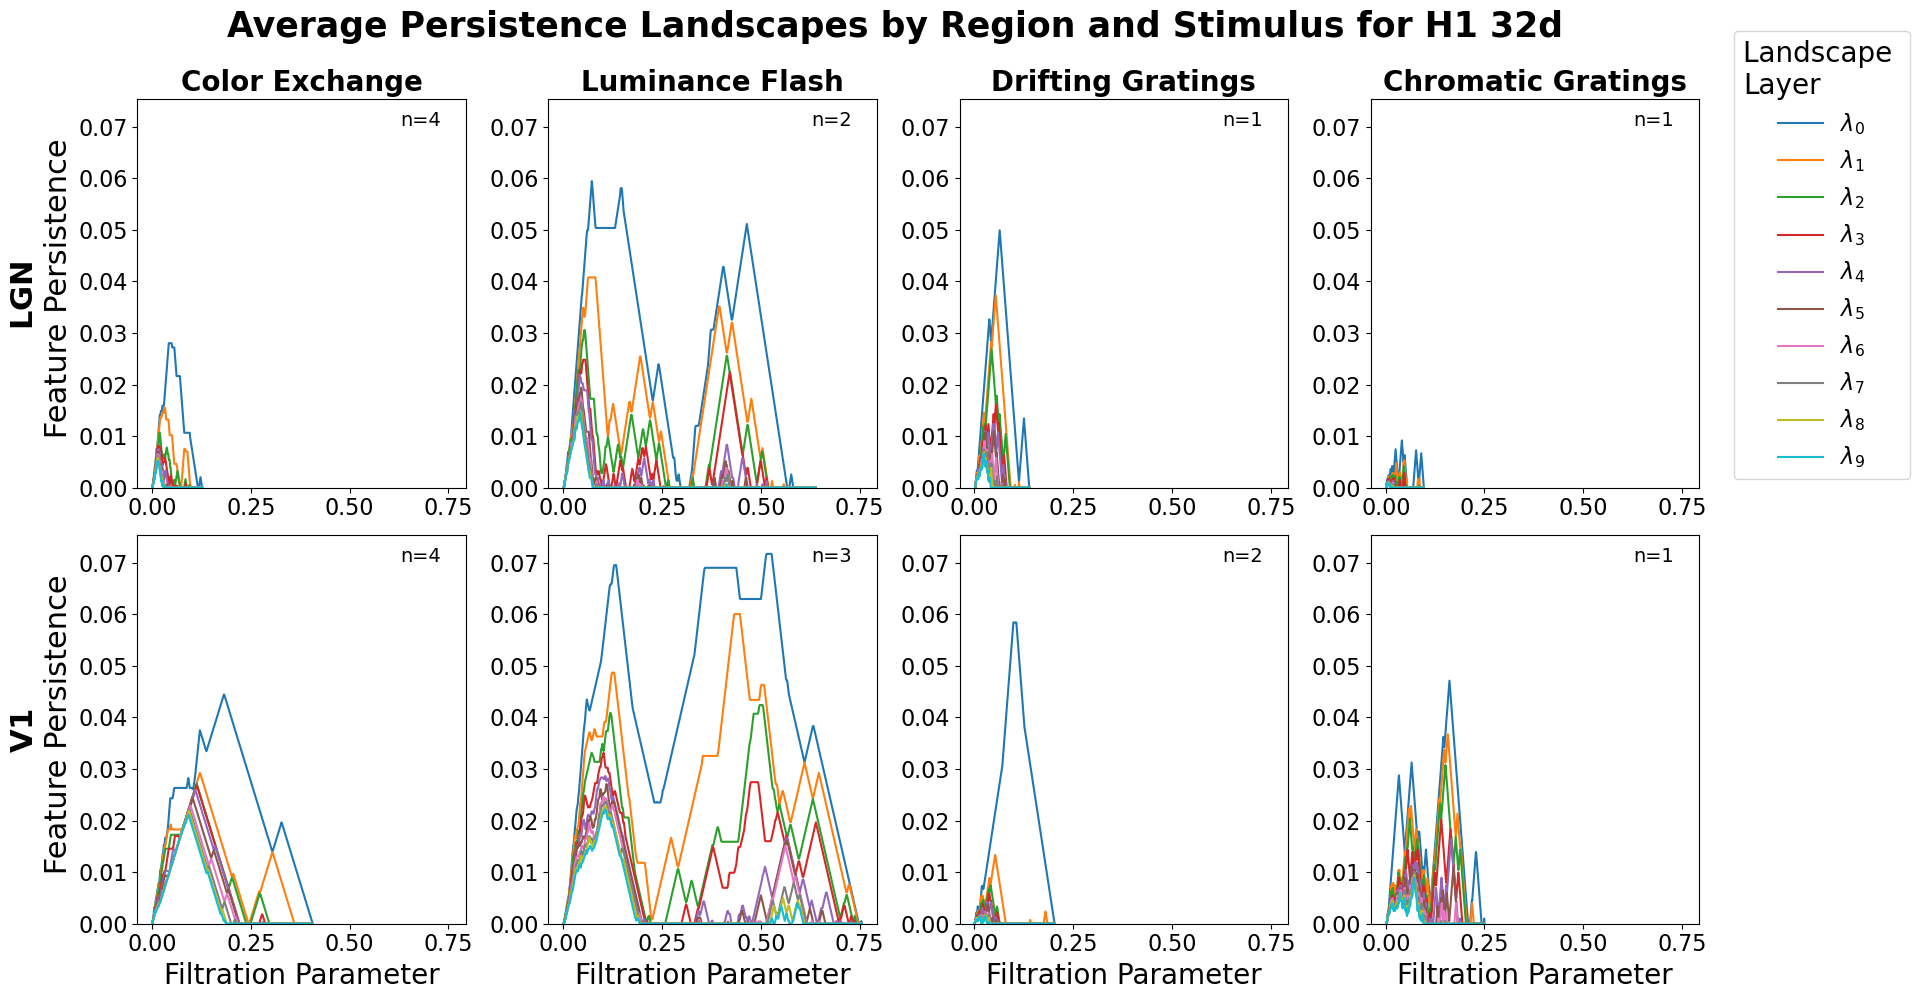

In [8]:
# plot all landscapes for V1 and LGN for each stimulus per homology group

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# set landscapes and labels
landscapes = {
    'LGN': {
        'CEX': avg_lgn_CEX_landscape,
        'LF': avg_lgn_LF_landscape,
        'DG': avg_lgn_DG_landscape,
        'CG': avg_lgn_CG_landscape
    },
    'V1': {
        'CEX': avg_v1_CEX_landscape,
        'LF': avg_v1_LF_landscape,
        'DG': avg_v1_DG_landscape,
        'CG': avg_v1_CG_landscape
    }
}

landscape_inputs = {
    'LGN': {
        'CEX': lgn_CEX_landscape,
        'LF': lgn_LF_landscape,
        'DG': lgn_DG_landscape,
        'CG': lgn_CG_landscape
    },
    'V1': {
        'CEX': v1_CEX_landscape,
        'LF': v1_LF_landscape,
        'DG': v1_DG_landscape,
        'CG': v1_CG_landscape
    }
}

def count_diagrams_for_pl(pl, hom_deg):
    """ Counts the number of diagrams in a persistence landscape

    Args:
        pl: PersLandscapeApprox object
        hom_deg: int homology group degree
    Returns:
    diag_source = None """

    for attr in ('dgms', '_dgms', 'diagrams', '_diagrams'):
        if hasattr(pl, attr):
            diag_source = getattr(pl, attr)
            if diag_source is not None:
                break
    if diag_source is None:
        return 1
    if isinstance(diag_source, dict):
        diag_source = diag_source.get(hom_deg, diag_source)
    if isinstance(diag_source, (list, tuple)):
        if len(diag_source) == 0:
            return 0
        first = diag_source[0]
        if isinstance(first, np.ndarray):
            if first.ndim == 2 and first.shape[-1] >= 2:
                return len(diag_source)
            if first.ndim == 1 and len(first) >= 2:
                return 1
        if isinstance(first, (list, tuple)):
            if len(first) >= 2 and all(isinstance(x, (int, float, np.integer, np.floating)) for x in first[:2]):
                return 1
            return len(diag_source)
        return len(diag_source)
    return 1

def count_dgms_for_landscape_group(pl_list, hom_deg):
    """ Counts the number of diagrams in a list of persistence landscapes

    Args:
        pl_list: list of PersLandscapeApprox objects
        hom_deg: int homology group degree
    Returns:
        int number of diagrams"""

    return sum(count_diagrams_for_pl(pl, hom_deg) for pl in pl_list)

stimuli = ['CEX', 'LF', 'DG', 'CG']
regions = ['LGN', 'V1']

counts = {
    region: {
        stim: count_dgms_for_landscape_group(landscape_inputs[region][stim], hom_deg)
        for stim in stimuli
    }
    for region in regions
}

# calculate global x and y limits across all landscapes
all_x_values = []
all_y_values = []

for region in regions:
    for stim in stimuli:
        landscape = landscapes[region][stim]
        try:
            xs = landscape.grid
        except AttributeError:
            try:
                xs = landscape.xs
            except AttributeError:
                xs = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
        
        try:
            landscapes_data = landscape.landscapes
        except AttributeError:
            try:
                landscapes_data = landscape.values
            except AttributeError:
                landscapes_data = landscape.Ls
        
        all_x_values.extend(xs)
        n_layers = min(10, len(landscapes_data))
        for i in range(n_layers):
            all_y_values.extend(landscapes_data[i])

# global limits
x_min = min(all_x_values)
x_max = max(all_x_values)
y_min = min(all_y_values)
y_max = max(all_y_values)

# add small padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min = max(0, y_min - y_padding)
y_max += y_padding

# lplot landscapes 
for row_idx, region in enumerate(regions):
    for col_idx, stim in enumerate(stimuli):
        ax = axes[row_idx, col_idx]
        landscape = landscapes[region][stim]
        
        plt.sca(ax)
        plot_landscape_simple(landscape, title="", depth_range=range(10))
        ax.legend().remove()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)

        ax.text(
            0.8,
            0.97,
            f"n={counts[region][stim]}",
            transform=ax.transAxes,
            fontsize=14,
            ha='left',
            va='top',
            bbox=dict(facecolor='white', alpha=0, edgecolor='none')
        )

        if row_idx == 0:
            ax.set_title(f"{stim}", fontsize=20, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f"$\\bf{{{region}}}$ \n Feature Persistence", fontsize=22)
        if row_idx == 1:
            ax.set_xlabel("Filtration Parameter", fontsize=20)

handles, labels = axes[0, 0].get_legend_handles_labels()
if len(handles) == 0:
    handles = [Line2D([0], [0], color=plt.cm.viridis(i/9), linewidth=1.5) for i in range(10)]
    labels = [f'λ{i}' for i in range(10)]

axes[0,0].set_title("Color Exchange", fontsize=20, fontweight='bold')
axes[0,1].set_title("Luminance Flash", fontsize=20, fontweight='bold')
axes[0,2].set_title("Drifting Gratings", fontsize=20, fontweight='bold')
axes[0,3].set_title("Chromatic Gratings", fontsize=20, fontweight='bold')
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.75), title='Landscape \nLayer', fontsize=16, title_fontsize=20)
fig.suptitle(f'Average Persistence Landscapes by Region and Stimulus for H{hom_deg} {dim}', fontsize=25, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 0.96, 1])
plt.show()


## 6. AUC analysis

In [9]:
# utils for AUC
# RUN ME

def landscape_auc_persim_any(pl, n_layers=None, x_min=None, x_max=None, n_bins=None, return_per_layer=False):
    """
    Compute AUC for a persim PersLandscapeApprox regardless of internal attribute names.

    Args:
        pl: PersLandscapeApprox object
        n_layers: int number of lambda function layers to include in AUC calculation
        x_min: float minimum x value to include in AUC calculation
        x_max: float maximum x value to include in AUC calculation
        n_bins: int number of bins to use in AUC calculation
        return_per_layer: bool whether to return per-layer AUCs

    Returns:
        total_auc: float total AUC
        per_layer_auc: np.ndarray per-layer AUCs"""

    Y_native = _get_Y_from_pl(pl) 
    # normalize to (layers, points)
    if Y_native.ndim == 1:
        Y_native = Y_native[None, :]
    # guess x-grid length
    n_points = Y_native.shape[-1]
    xs_native = _get_xs_from_pl(pl, n_points_hint=n_points)

    # ff orientation is (points, layers), transpose
    if Y_native.shape[0] == xs_native.size and Y_native.shape[1] != xs_native.size:
        Y_native = Y_native.T

    # trim layers if needed
    if n_layers is not None:
        Y_native = Y_native[:n_layers, :]

    # integration window
    if x_min is None: x_min = float(xs_native.min())
    if x_max is None: x_max = float(xs_native.max())
    if x_min >= x_max:
        raise ValueError("x_min must be < x_max.")

    mask = (xs_native >= x_min) & (xs_native <= x_max)
    xs = xs_native[mask]
    Y = Y_native[:, mask]

    # optional resampling to uniform count
    if n_bins is not None and n_bins > 1:
        xs_uniform = np.linspace(x_min, x_max, int(n_bins))
        Y = np.vstack([np.interp(xs_uniform, xs, y) for y in Y])
        xs = xs_uniform

    # integrate
    Y = np.nan_to_num(Y, copy=False)
    per_layer_auc = np.trapz(Y, xs, axis=1)
    total_auc = float(per_layer_auc.sum())

    return (total_auc, per_layer_auc) if return_per_layer else (total_auc, None)
    
def _get_xs_from_pl(pl, n_points_hint) -> np.ndarray:
    """ Get x-values from a PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
        n_points_hint: int number of points to use in x-grid
    Returns:
        np.ndarray x-values"""

    for attr in ("grid", "xs", "x_values"):
        xs = getattr(pl, attr, None)
        if xs is not None:
            return np.asarray(xs).ravel()

    # try start/stop/num_steps trio
    if all(hasattr(pl, a) for a in ("start", "stop", "num_steps")):
        return np.linspace(float(pl.start), float(pl.stop), int(pl.num_steps))

    # try x_range
    xr = getattr(pl, "x_range", None)
    if xr is not None and n_points_hint is not None:
        return np.linspace(float(xr[0]), float(xr[1]), int(n_points_hint))

    # or just make an index grid
    if n_points_hint is not None:
        return np.arange(int(n_points_hint), dtype=float)

    raise TypeError("Could not infer x-grid from PersLandscapeApprox (no grid/xs/start/stop/num_steps/x_range).")


def _get_Y_from_pl(pl) -> np.ndarray:
    """ Get Y-values from a PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
    Returns:
        np.ndarray Y-values"""

    for attr in ("values", "landscapes", "Ls", "y_values", "_values", "_landscapes"):
        Y = getattr(pl, attr, None)
        if Y is not None:
            Y = np.asarray(Y, dtype=float)
            return Y

    # if there is a method that returns landscape arrays
    for meth in ("landscapes", "to_numpy", "as_array"):
        f = getattr(pl, meth, None)
        if callable(f):
            Y = np.asarray(f(), dtype=float)
            return Y

    # try iterating (list of layers)
    try:
        Y = np.asarray(list(pl), dtype=float)
        return Y
    except Exception:
        pass

    raise TypeError("Could not extract landscape values from PersLandscapeApprox (no values/landscapes/Ls).")

## 7. Calculate metrics across embedding dimension

Investigates if lowering embedding dimensionality collapses important topological features

This is measured through:
- **AUC** - total persistence of features
- **peak position**
    - max y-axis value of 0th lambda function 
        - describes the most persistent topological feature
- **active layer count**
    - counts "active layers" of persistence diagram where y >= 1e-6
        - metric for total topological complexity

Args that can be changed:
- ```hom_deg``` = specifies homology group of the dgms to use

- ```embedding_dims``` = can edit this list to restrict embedding dimensions used

- ```region``` = can edit to restrict to one brain region dgms

In [ ]:
#  AUC, peak position, and active layer count across embedding dimensions and stimuli

hom_deg = 1 # change to evaluate other homology groups (0, 1, or 2)
embedding_dims = ['3d', '8d', '24d', '32d'] # can restrict to specific dims or use all
regions = ['LGN', 'V1'] # brain regions
shuffled = False  # True for shuffled, False for non-shuffled


stim_code_map = {
    'cex': 'Color Exchange',
    'lf': 'Luminance Flash',
    'dg': 'Drifting Gratings',
    'cg': 'Chromatic Gratings'
}


metrics_records = []

for dim_label in embedding_dims:
    dim_value = int(dim_label.replace('d', ''))
    for region in regions:
        for stim_code, stim_name in stim_code_map.items():
            # use all_dgms_files
            matching_files = [
                f for f in all_dgms_files 
                if f.suffix == '.pkl' and dim_label in f.name and region in f.name and stim_code in f.name
                and (('shuffled' in f.name) if shuffled else ('shuffled' not in f.name))
            ]

            landscape_entries = []
            for fname in matching_files:
                dgms = data_manager.load_persistence_diagrams(fname)
                if dgms is None:
                    continue
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if len(dgms) <= hom_deg:
                    continue
                if dgms[hom_deg] is None or len(dgms[hom_deg]) == 0:
                    continue
                try:
                    pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    landscape_entries.append((fname, pl))
                except Exception as e:
                    print(f"  Error creating landscape for {fname.name}: {e}")
                    continue

            if not landscape_entries:
                print(f"  No valid landscapes for {region} {stim_name} {dim_label}")
                continue

            pls = [pl for _, pl in landscape_entries]
            try:
                if len(pls) > 1:
                    aligned_pls = snap_pl(pls)
                else:
                    aligned_pls = pls
            except Exception:
                aligned_pls = pls

            for (fname, orig_pl), snapped_pl in zip(landscape_entries, aligned_pls):
                try:
                    auc_val, _ = landscape_auc_persim_any(snapped_pl)
                except Exception as e:
                    print(f"  Error calculating AUC for {fname.name}: {e}")
                    auc_val = np.nan

                try:
                    Y = _get_Y_from_pl(snapped_pl)
                    if Y.ndim == 1:
                        Y = Y[None, :]
                    xs = _get_xs_from_pl(snapped_pl, n_points_hint=Y.shape[-1])
                    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
                        Y = Y.T
                    Y = np.nan_to_num(Y, nan=0.0, posinf=0.0, neginf=0.0)
                    y_max_per_layer = np.max(Y, axis=1)
                    layer_count = int(np.sum(y_max_per_layer > 1e-6))
                    peak_idx = np.argmax(Y)
                    peak_pos = float(xs[np.unravel_index(peak_idx, Y.shape)[-1]])
                except Exception as e:
                    print(f"  Error calculating metrics for {fname.name}: {e}")
                    peak_pos = np.nan
                    layer_count = np.nan

                metrics_records.append({
                    'region': region,
                    'stimulus': stim_name,
                    'stim_code': stim_code,
                    'dimension': dim_label,
                    'dimension_numeric': dim_value,
                    'auc': auc_val,
                    'peak_position': peak_pos,
                    'layer_count': layer_count,
                    'diagram_count': count_diagrams_for_pl(orig_pl, hom_deg),
                    'file': fname.name
                })

if shuffled == True:
    shuffled_topo_metrics_df = pd.DataFrame(metrics_records)
else:
    topo_metrics_df = pd.DataFrame(metrics_records)

if topo_metrics_df.empty:
    print('No metrics could be computed for the selected configuration.')
else:
    
    # show sample AUC values to check for differences
    print("\nSample AUC values by stimulus:")
    sample_aucs = topo_metrics_df.groupby(['region', 'stimulus'])['auc'].agg(['count', 'mean', 'std']).round(6)
    print(sample_aucs)
    
    summary_df = (
        topo_metrics_df
        .groupby(['region', 'stimulus', 'stim_code', 'dimension', 'dimension_numeric'], as_index=False)
        .agg(
            auc_mean=('auc', 'mean'),
            auc_std=('auc', 'std'),
            auc_count=('auc', 'count'),
            peak_position_mean=('peak_position', 'mean'),
            peak_position_std=('peak_position', 'std'),
            peak_position_count=('peak_position', 'count'),
            layer_count_mean=('layer_count', 'mean'),
            layer_count_std=('layer_count', 'std'),
            layer_count_count=('layer_count', 'count'),
            diagram_count=('diagram_count', 'sum')
        )
    )

    display(summary_df.head())



/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_52730/1181130955.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  per_layer_auc = np.trapz(Y, xs, axis=1)



Sample AUC values by stimulus:
                           count      mean       std
region stimulus                                     
LGN    Chromatic Gratings      4  0.008958  0.014895
       Color Exchange         16  0.006833  0.007123
       Drifting Gratings       4  0.028848  0.038905
       Luminance Flash         7  0.022999  0.020252
V1     Chromatic Gratings      4  0.018022  0.011741
       Color Exchange         18  0.015769  0.044710
       Drifting Gratings       9  0.005629  0.007329
       Luminance Flash        12  0.072168  0.094191


,region,stimulus,stim_code,dimension,dimension_numeric,auc_mean,auc_std,auc_count,peak_position_mean,peak_position_std,peak_position_count,layer_count_mean,layer_count_std,layer_count_count,diagram_count
0,LGN,Chromatic Gratings,cg,24d,24,0.031206,NaN,1,0.093917,NaN,1,4425.0,NaN,1,1
1,LGN,Chromatic Gratings,cg,32d,32,0.001089,NaN,1,0.040857,NaN,1,1745.0,NaN,1,1
2,LGN,Chromatic Gratings,cg,3d,3,0.000146,NaN,1,0.018188,NaN,1,98.0,NaN,1,1
3,LGN,Chromatic Gratings,cg,8d,8,0.003389,NaN,1,0.120471,NaN,1,769.0,NaN,1,1
4,LGN,Color Exchange,cex,24d,24,0.018341,0.001406,4,0.079817,0.012428,4,713.5,71.014083,4,4


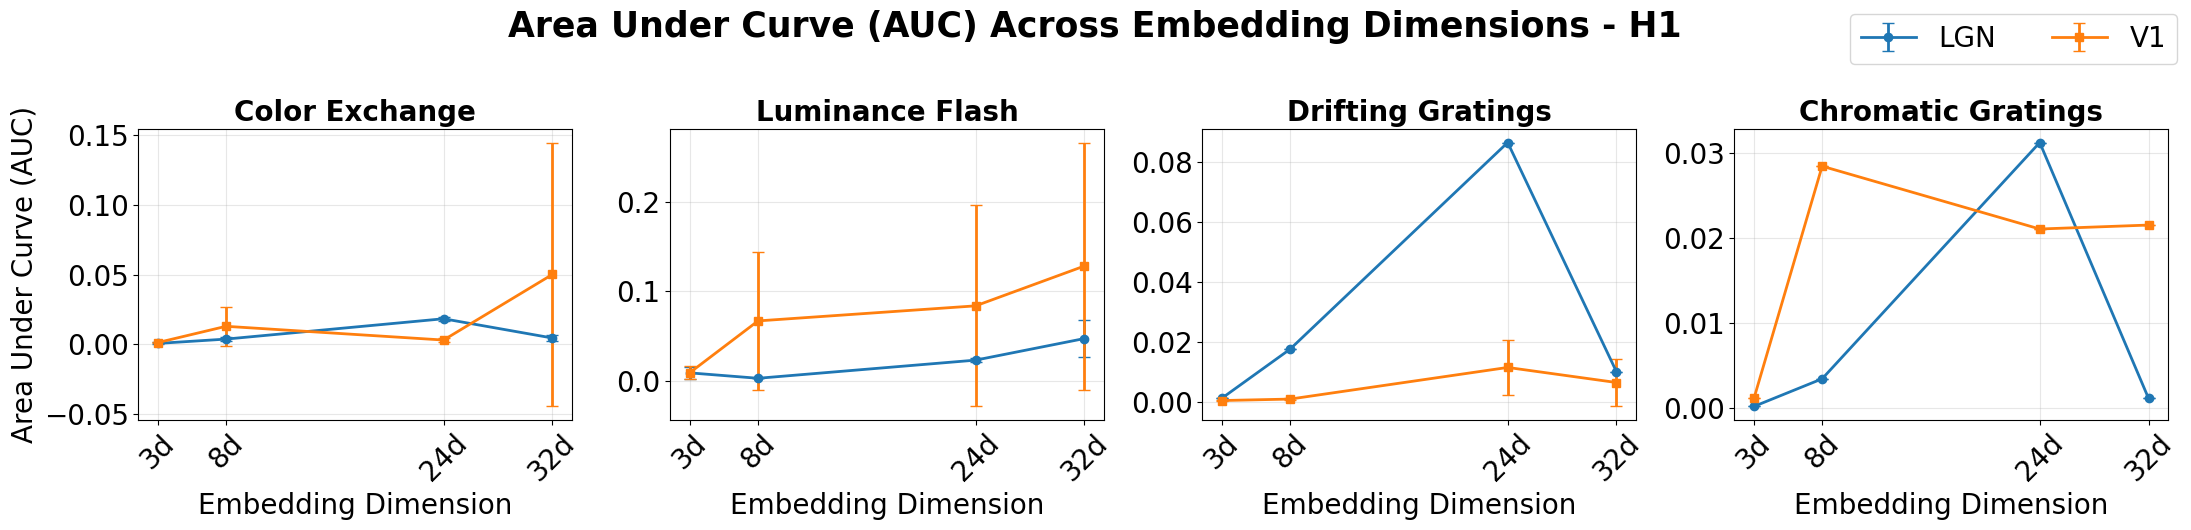

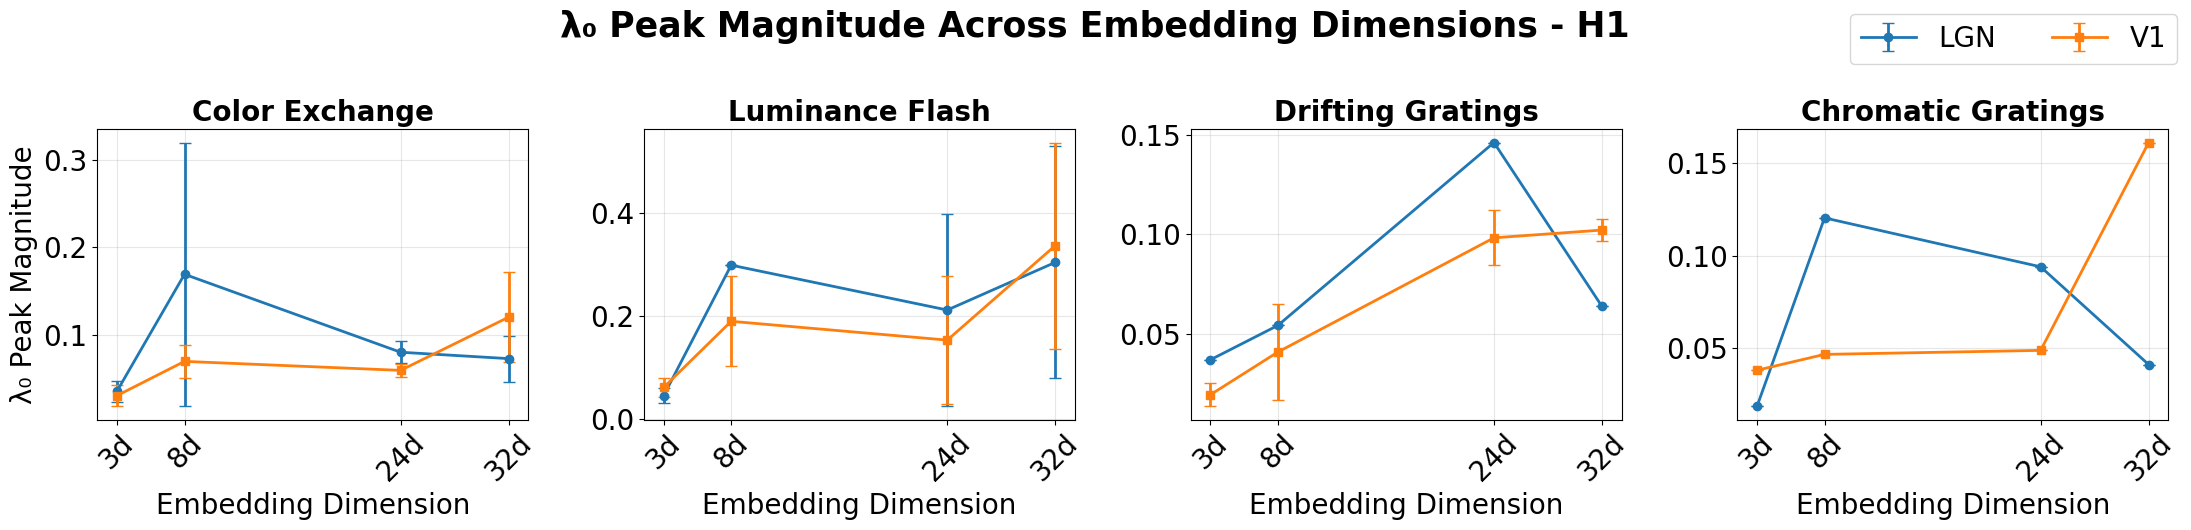

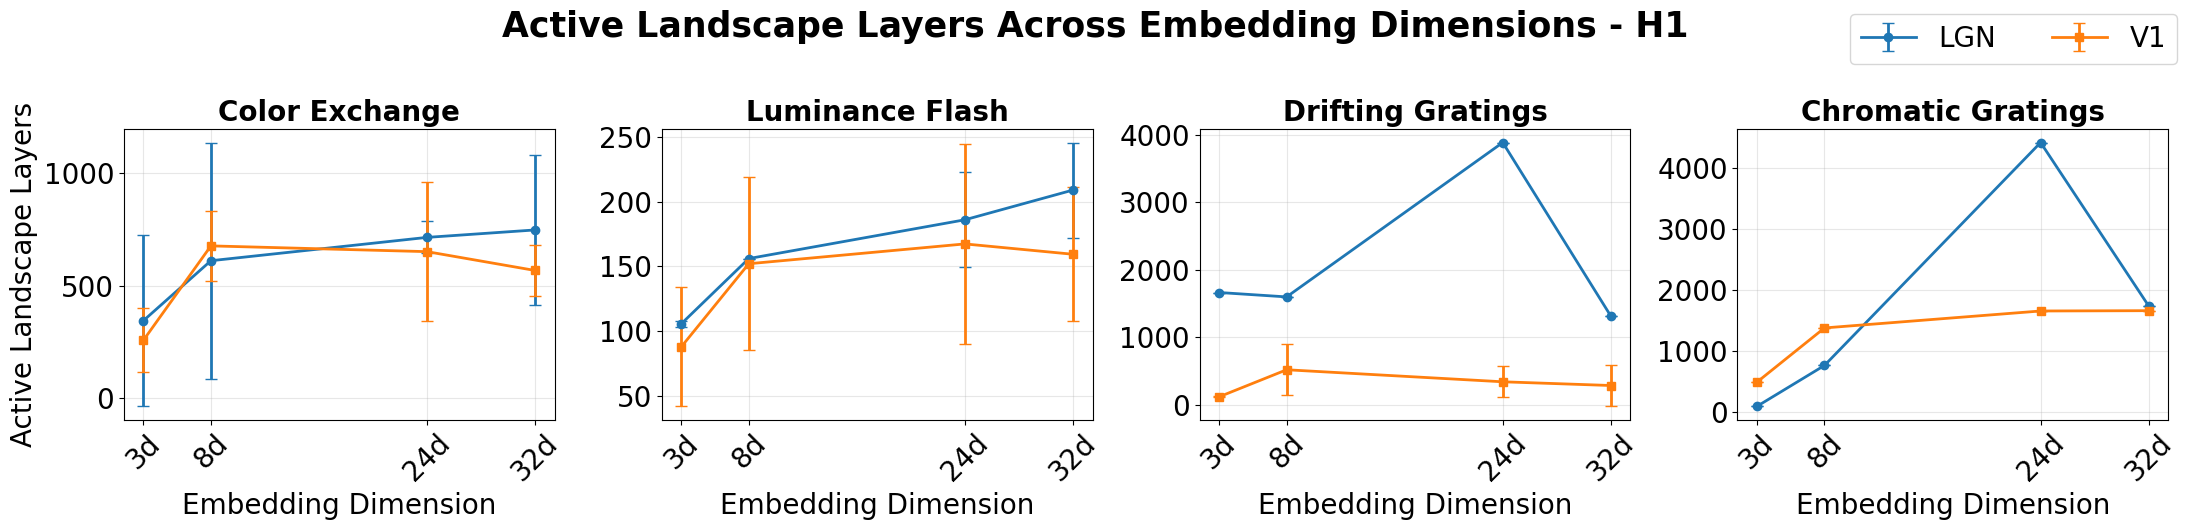

In [ ]:
# plots for AUC, peak position, and layer count across embedding dimensions
shuffled = False  # True for shuffled, False for non-shuffled

if shuffled:
    topo_metrics_df = shuffled_topo_metrics_df
    plot_shuffled = " -  Shuffled"
else:
    topo_metrics_df = topo_metrics_df
    plot_shuffled = ""

if topo_metrics_df.empty or summary_df.empty:
    print('No data available for plotting metrics across embedding dimensions.')
else:
    dim_numeric_order = [int(d.replace('d', '')) for d in embedding_dims]
    dim_label_map = dict(zip(dim_numeric_order, embedding_dims))
    stim_order = ['Color Exchange', 'Luminance Flash', 'Drifting Gratings', 'Chromatic Gratings']
    region_styles = {
        'LGN': {'color': 'tab:blue', 'marker': 'o'},
        'V1': {'color': 'tab:orange', 'marker': 's'}
    }

    metric_specs = [
        ('auc', 'Area Under Curve (AUC)'),
        ('peak_position', 'λ\u2080 Peak Magnitude'),
        ('layer_count', 'Active Landscape Layers')
    ]

    for metric, metric_label in metric_specs:
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'

        fig, axes = plt.subplots(1, len(stim_order), figsize=(22, 5), sharey=False)
        if len(stim_order) == 1:
            axes = [axes]

        legend_handles = {}

        for ax, stim in zip(axes, stim_order):
            stim_data = summary_df[summary_df['stimulus'] == stim]
            for region, style in region_styles.items():
                region_data = (
                    stim_data[stim_data['region'] == region]
                    .sort_values('dimension_numeric')
                )
                if region_data.empty:
                    continue
                y = region_data[mean_col]
                yerr = region_data[std_col].fillna(0.0)
                counts = region_data['diagram_count'].fillna(0).astype(int)
                handle = ax.errorbar(
                    region_data['dimension_numeric'],
                    y,
                    yerr=yerr,
                    label=region,
                    color=style['color'],
                    marker=style['marker'],
                    linewidth=2,
                    capsize=4
                )
                legend_handles[region] = handle

                if not y.dropna().empty:
                    y_min_val = np.nanmin(y)
                    y_max_val = np.nanmax(y)
                    y_range = y_max_val - y_min_val
                    if not np.isfinite(y_range) or y_range == 0:
                        y_range = 1.0
                else:
                    y_range = 1.0

                for x_val, y_val, count_val in zip(region_data['dimension_numeric'], y, counts):
                    if not np.isfinite(y_val):
                        continue
                    # ax.text(   -> adds n per point, seemed to busy on the plot to include this
                    #     x_val,
                    #     y_val + 0.03 * y_range,
                    #     f'n={count_val}',
                    #     fontsize=12,
                    #     color=style['color'],
                    #     ha='center',
                    #     va='bottom'
                    # )

            ax.set_title(stim, fontsize=20, fontweight='bold')
            ax.set_xlabel('Embedding Dimension', fontsize=20)
            ax.grid(alpha=0.3)
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)
            ax.set_xticks(dim_numeric_order)
            ax.set_xticklabels([dim_label_map[d] for d in dim_numeric_order], rotation=45, fontsize=20)
        axes[0].set_ylabel(metric_label, fontsize=20)

        if legend_handles:
            fig.legend(legend_handles.values(), legend_handles.keys(), loc='upper right', ncol=len(region_styles), fontsize=20, title_fontsize=20)
        fig.suptitle(f'{metric_label} Across Embedding Dimensions - H{hom_deg} {plot_shuffled}', fontsize=25, y=1.05, fontweight='bold')
        plt.tight_layout()
        plt.show()


## 8. Plot 0th lambda functions for each stimuli per brain region by homology group
- the 0th lambda function describes the *most* prominent/persistent feature. these features are less likely to be noise, unlike higher rank lamdba functions

Args that can be changed:
- ```region``` = switch between LGN and V1 with this string

- ```hom_deg_plot``` = specifies which homology group dgms will be plotted

/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_52730/3274861502.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(np.nan_to_num(lambda0, nan=0.0), xs))


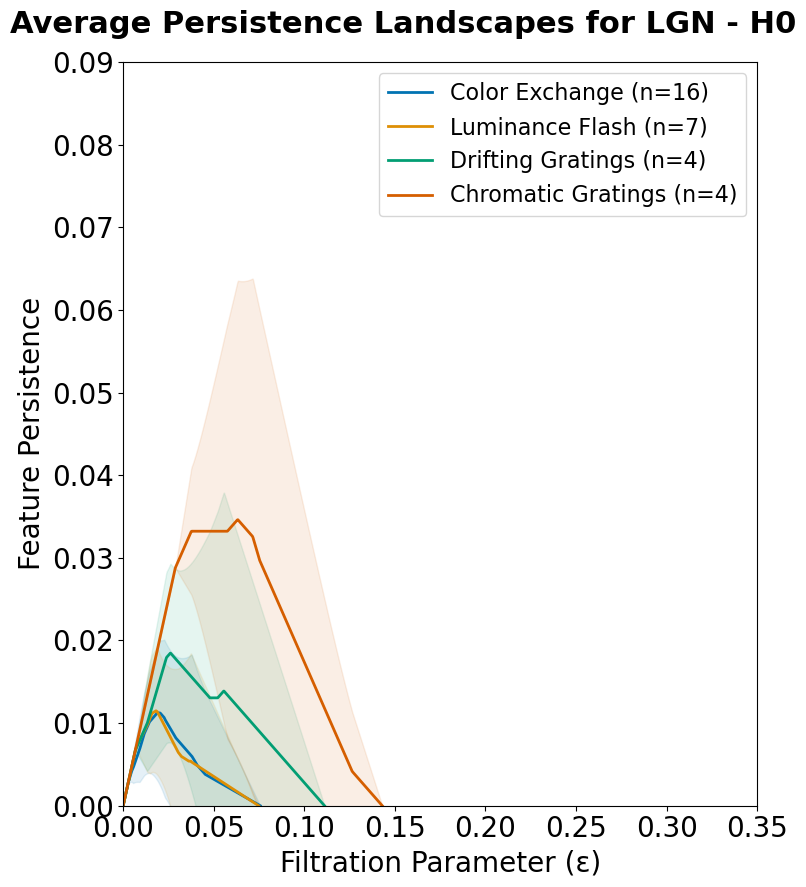

AUC table saved to: /Users/emilyekstrum/repos/TDA/notebooks/v1_h0_lambda0_auc.csv


,Total Persistence (AUC)
Stimulus,
Color Exchange,0.000386
Luminance Flash,0.000381
Drifting Gratings,0.001096
Chromatic Gratings,0.002840


In [ ]:
# Plots a single homology group lambda 0 function landscape per brain region with all stimuli 

region = 'LGN' # 'LGN' or 'V1'
hom_deg_plot = 0 # 0, 1, or 2
shuffled = False  # True for shuffled, False for non-shuffled

if shuffled:
    all_dgms_files_region = [f for f in all_dgms_files if 'shuffled' in f.name and region in f.name]
    plot_title_shuffled = "Shuffled"
else:
    all_dgms_files_region = [f for f in all_dgms_files if 'shuffled' not in f.name and region in f.name]
    plot_title_shuffled = ""

stim_code_map = {
    'cex': 'Color Exchange',
    'lf': 'Luminance Flash',
    'dg': 'Drifting Gratings',
    'cg': 'Chromatic Gratings'
}

def lambda0_auc(pl):
    """ Calculate the AUC of the lambda_0 layer of a persistence landscape

    Args:
        pl: PersLandscapeApprox object
    Returns:
        float AUC of the lambda_0 layer"""

    Y = _get_Y_from_pl(pl)
    if Y.ndim == 1:
        Y = Y[None, :]
    xs = _get_xs_from_pl(pl, n_points_hint=Y.shape[-1])
    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
        Y = Y.T
    lambda0 = Y[0]
    return float(np.trapz(np.nan_to_num(lambda0, nan=0.0), xs))

# Use all_dgms_files instead of pkl_files
v1_files_by_stim = {
    stim_name: [
        f for f in all_dgms_files
        if f.suffix == '.pkl' and region in f.name and stim_code in f.name and 'd' in f.name]
    for stim_code, stim_name in stim_code_map.items()
}

def collect_landscapes(file_list, hom_deg):
    """  Collect persistence landscapes from a list of files

    Args:
        file_list: list of file paths
        hom_deg: int homology group degree

    Returns:
        avg_pl: PersLandscapeApprox object average persistence landscape
        aligned_pls: list of PersLandscapeApprox objects aligned persistence landscapes
        count: int number of valid persistence landscapes"""

    pls = []
    count = 0
    for fname in file_list:
        # Use data_manager to load files properly
        dgms = data_manager.load_persistence_diagrams(fname)
        if dgms is None:
            continue
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        if len(dgms) <= hom_deg:
            continue
        dgm = dgms[hom_deg]
        if dgm is None or len(dgm) == 0:
            continue
        try:
            pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
        except Exception:
            continue
        pls.append(pl)
        count += 1
    if not pls:
        return None, None, 0
    try:
        avg_pl = average_approx(pls)
        aligned_pls = snap_pl(pls) if len(pls) > 1 else pls
    except Exception:
        return None, None, count
    return avg_pl, aligned_pls, count

avg_v1_h0_by_stim = {}
all_pls_by_stim = {}
counts_v1_h0 = {}
auc_v1_h0 = {}
for stim_code, stim_name in stim_code_map.items():
    avg_pl, aligned_pls, count = collect_landscapes(v1_files_by_stim[stim_name], hom_deg_plot)
    avg_v1_h0_by_stim[stim_name] = avg_pl
    all_pls_by_stim[stim_name] = aligned_pls
    counts_v1_h0[stim_name] = count
    auc_v1_h0[stim_name] = lambda0_auc(avg_pl) if avg_pl is not None else np.nan

stim_order = ['Color Exchange', 'Luminance Flash', 'Drifting Gratings', 'Chromatic Gratings']
color_palette = sns.color_palette('colorblind', len(stim_order))
fig, ax = plt.subplots(figsize=(8, 9))

for color, stim_name in zip(color_palette, stim_order):
    avg_pl = avg_v1_h0_by_stim.get(stim_name)
    aligned_pls = all_pls_by_stim.get(stim_name, [])
    count = counts_v1_h0.get(stim_name, 0)
    if avg_pl is None:
        continue
    
    Y = _get_Y_from_pl(avg_pl)
    if Y.ndim == 1:
        Y = Y[None, :]
    xs = _get_xs_from_pl(avg_pl, n_points_hint=Y.shape[-1])
    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
        Y = Y.T
    lambda0_mean = Y[0]
    
    if aligned_pls and len(aligned_pls) > 1:
        lambda0_all = []
        for pl in aligned_pls:
            Y_pl = _get_Y_from_pl(pl)
            if Y_pl.ndim == 1:
                Y_pl = Y_pl[None, :]
            xs_pl = _get_xs_from_pl(pl, n_points_hint=Y_pl.shape[-1])
            if Y_pl.shape[0] == xs_pl.size and Y_pl.shape[1] != xs_pl.size:
                Y_pl = Y_pl.T
            lambda0_pl = Y_pl[0]
            if len(lambda0_pl) == len(xs):
                lambda0_all.append(lambda0_pl)
            else:
                lambda0_interp = np.interp(xs, xs_pl, lambda0_pl)
                lambda0_all.append(lambda0_interp)
        
        if lambda0_all:
            lambda0_all = np.array(lambda0_all)
            lambda0_std = np.std(lambda0_all, axis=0)
            ax.fill_between(xs, lambda0_mean - lambda0_std, lambda0_mean + lambda0_std, 
                           alpha=0.1, color=color)
    
    ax.plot(xs, lambda0_mean, linewidth=2, color=color, label=f"{stim_name} (n={count})")

ax.set_xlabel('Filtration Parameter (ε)', fontsize=20)
ax.set_ylim(0, 0.09)
ax.set_xlim(0, 0.35)
ax.set_ylabel('Feature Persistence', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.legend(fontsize=16)
fig.suptitle(f'Average Persistence Landscapes for {plot_title_shuffled} {region} - H{hom_deg_plot}', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

auc_table = pd.DataFrame({
    'Stimulus': stim_order,
    #'n_diagrams': [counts_v1_h0[s] for s in stim_order],
    'Total Persistence (AUC)': [np.round(auc_v1_h0[s], 6) for s in stim_order]
}).set_index('Stimulus')

export_path = os.path.join(os.getcwd(), 'v1_h0_lambda0_auc.csv')
#auc_table.to_csv(export_path)
print(f"AUC table saved to: {export_path}")

display(auc_table)